In [1]:
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import os

In [2]:
### https://www.analyticsvidhya.com/blog/2020/10/reinforcement-learning-stock-price-prediction/
### https://blog.quantinsti.com/reinforcement-learning-trading/
### https://www.mlq.ai/deep-reinforcement-learning-trading-strategies-automl/

In [3]:
'''
Building blocks:
    Action: [Buy, Sell, Hold]
    Policy: Exploration | Exploitation
    State: Closing on each day
    Rewards: % Returns
    Environment: Current shares held

Q-Table & Q-Learning:
    1. Start with reward table
    2. Calculate Q-table using Bellman Equation
'''

'\nBuilding blocks:\n    Action: [Buy, Sell, Hold]\n    Policy: Exploration | Exploitation\n    State: Closing on each day\n    Rewards: % Returns\n    Environment: Current shares held\n\nQ-Table & Q-Learning:\n    1. Start with reward table\n    2. Calculate Q-table using Bellman Equation\n'

In [4]:
class args:
    lr = 0.0001
    epochs = 1
    batch_size=32
    no_cuda = False
    use_cuda = not no_cuda and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')

In [ ]:
print(args.device)

In [5]:
appen_data = pd.read_csv('APX.AX.csv')
appen_data.columns
print(appen_data['Close'])

0        0.580000
1        0.580000
2        0.570000
3        0.570000
4        0.595000
          ...    
1515    22.510000
1516    22.540001
1517    22.520000
1518    22.700001
1519    22.320000
Name: Close, Length: 1520, dtype: float64


In [6]:
print(torch.cuda.is_available())

False


In [7]:
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        label = self.target[index]

        return data, label

In [8]:
def train(X, Y, epochs, batch_size, net, action):
    train_dataset = CustomDataset(X, Y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # use SGD optimizer
    optimiser = optim.Adam(net.parameters(), lr=args.lr)

    running_loss = 0
    for epoch in range(epochs):
        optimiser.zero_grad()
        for i, (data, target) in enumerate(train_loader):
            # Get a batch and potentially send it to GPU memory.
            inputs, target = data.to(args.device), target.to(args.device)
            # PyTorch calculates gradients by accumulating contributions to them
            # (useful for RNNs).  Hence we must manually set them to zero before
            # calculating them.
            # Forward pass through the network.
            out = net(inputs.float())

            m = nn.MSELoss()
            
            loss = m(out[0][action], target[0][action].detach())
            
            running_loss = loss.item()

            # Calculate gradients.
            loss.backward()

            # Minimise the loss according to the gradient.
            optimiser.step()

            #print('Loss = ', loss.item())
    return running_loss

In [20]:
class Q_model(nn.Module):
    def __init__(self):
        super(Q_model, self).__init__()
        self.lstm = nn.LSTM(20, 50, 2, batch_first=True, dropout=0.1)
        self.linear = nn.Linear(50, 3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #x = torch.tensor(x).flatten()
        x = torch.tensor(x)
        x = x.unsqueeze_(0).float()
        #x = torch.tensor(x).unsqueeze_(0).float()
        out, z = self.lstm(x)
        out = self.linear(out)
        return out.squeeze_(0)

In [21]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=''):
        self.state_size = state_size
        self.memory = deque(maxlen=1000)
        self.action_size = 3
        self.inventory = []
        self.is_eval = False
        self.gamma = 0.95   
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.model = load_model(model_name) if is_eval else Q_model().to(args.device)

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        out = self.model(state)
        return torch.argmax(out[0])

    def expReplay(self, batch_size):
        mini_batch = random.sample(self.memory, args.batch_size)
        batch_state = []
        batch_q_vals = []
        running_loss = 0
        for state, action, reward, next_state, done in mini_batch:
            action = int(action)
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)[0])
            q_vals = self.model(state)
            q_vals[0][action] = target
            batch_state.append(state.flatten())
            batch_q_vals.append(q_vals.flatten())

        running_loss = train(batch_state, batch_q_vals, 1, args.batch_size, self.model, action)
        #if self.epsilon > self.epsilon_min:
        #    self.epsilon *= self.epsilon_decay
        return running_loss

In [22]:
def sigmoid(x):
    if x < 0:
        return 1 - 1 / (1 + math.exp(x))
    return 1 / (1 + math.exp(-x))

In [23]:
def get_state(data, t, n_days):
    """Returns an n-day state representation ending at time t
    """
    d = t - n_days + 1
    pad = -d * [data[0]]
    neg_block = data[0:t+1].tolist()
    neg_block.extend(pad)
    block = data[d: t + 1].tolist() if d >= 0 else neg_block  # pad with t0
    res = []
    for i in range(n_days - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

In [24]:
window_size = 20
episode_count = 100
agent = Agent(window_size, model_name='100')
data = appen_data['Close']
l = len(data) - 1
profits = []
loss = 0
for ep in range(episode_count+1):
    #print("Episode " + str(ep) + "/" + str(episode_count))
    state = get_state(data, 0, window_size + 1)
    #state = np.array([data[0: window_size]])
    total_profit = 0
    loss = 0
    agent.inventory = []
    for t in range(l):
        action = agent.act(state)

        # If sit - i.e. action == 0
        next_state = get_state(data, t + 1, window_size + 1)
        #next_state = np.array([data[t+1: t + window_size + 1]])
        reward = 0

        # If buy - i.e. action == 1
        if action == 1:
            agent.inventory.append(data[t])
            #print('Buy: ', data[t])

        # If sell - i.e. action == 2
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = data[t] - bought_price
            total_profit += reward
            #print('Sell: ' + str(data[t]) + ' | Profit: ' + str(data[t] - bought_price))
        done = (t==l-1)
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            print("--------------------------------")
            print(f"Episode: {ep} | Total Profit: {total_profit}")
            print(f"Loss: {loss}")
            print(f"Epsilon: {agent.epsilon}")
            print("--------------------------------")
            profits.append(total_profit)
            if agent.epsilon > agent.epsilon_min:
                agent.epsilon *= agent.epsilon_decay
        
        if len(agent.memory) > args.batch_size:
            loss = agent.expReplay(args.batch_size)
            if t % 50 == 0:
                print(f"Window {t}: Loss {loss}")
    if ep % 10 == 0:
        torch.save(agent.model.state_dict(), str(ep) + '.pth')

 Loss 2.921025421542822e-09
Window 1050: Loss 1.4523417135592354e-08
Window 1100: Loss 1.5881570334386197e-06
Window 1150: Loss 4.3001514882234915e-07
Window 1200: Loss 1.7507222338508655e-08
Window 1250: Loss 1.65449582709698e-05
Window 1300: Loss 4.531443380528799e-07
Window 1350: Loss 5.51176668750486e-08
Window 1400: Loss 2.2402522859010787e-07
Window 1450: Loss 1.3260601008369122e-06
Window 1500: Loss 95.61873626708984
--------------------------------
Episode: 86 | Total Profit: 6217.649993000005
Loss: 2.1014802769059315e-06
Epsilon: 0.012140317781059323
--------------------------------
Window 0: Loss 2.9472744245140348e-06
Window 50: Loss 4.4815333239967e-06
Window 100: Loss 4.206950507068541e-06
Window 150: Loss 1.0302553619112587e-06
Window 200: Loss 8.949859875428956e-06
Window 250: Loss 166.8478546142578
Window 300: Loss 78.35071563720703
Window 350: Loss 0.00011661868484225124
Window 400: Loss 2.580518412287347e-07
Window 450: Loss 2.0400631910888478e-05
Window 500: Loss 2.0

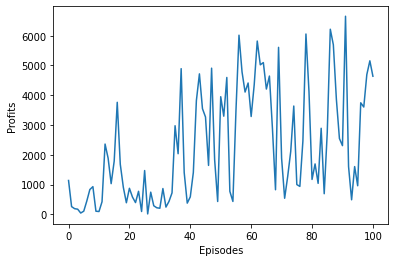

In [25]:
plt.plot([i for i in range(episode_count+1)], profits)
plt.xlabel('Episodes')
plt.ylabel('Profits')
plt.savefig('Profits per eps.png')
plt.show()